- - - -
# Photophysics of Fluorescence
- - - -

Troy Messina @ Berea College

- - - -

**1) Load UV-Vis, excitation/emission, lifetime data**    
**2) Plot Data**  
**3) Curve Fitting**  

- - - -

This is a smattering of scripts to work with data collected from fluorescence instruments. To begin, a fluorescent sample is needed. This tutorial will follow sample preparation and similar measurements to Prendergast et al., "Synthesis, Spectral Properties, and Use of 6-Acryloyl-2-dimethylaminonaphthalene (Acrylodan): A THIOL-SELECTIVE, POLARITY-SENSITIVE FLUORESCENT PROBE", *J. Biol. Chem.*, Vol. 258, No. 12, Issue of June 25, pp. 7541-7544. 1983.

To measure the absorption on the Ocean Optics UV-Vis

1. Turn on deuterium lamp.
2. Turn on halogen lamp.
3. Turn on rear switch.
4. Turn shutter to off.
5. Open Ocean Optics software (OceanView) and select the Absorbance wizard.
6. Click "Next" to go the Reference Spectrum.
7. Put a cuvette with solvent into the spectrometer.
8. Turn shutter on.
9. Click the light bulb image to collect the reference spectrum. The spectrum should have a UV and visible spectrum.
10. Click "Next".
11. Turn shutter off.
12. Click the bulb image for a dark background. The spectrum should look like noise level across the spectrum.
13. Click "Finish".
14. Insert a sample cuvette.
15. Turn shutter on.

Integration time will affect the reference. So, it is better to increase the number of spectra averaged if the spectrum is too noisy. Save the spectrum to a text file using the save to file icon on at the top of the graph. It should save to your "Documents" folder.

In [4]:
# import modules
import pandas as pd
import numpy as np
from numpy import array, arange, pi, exp, sin, cos, polyfit, poly1d, linspace, zeros, flipud
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import fmin
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

We need to be able to load data from three different instruments, the Ocean Optics UV-VIS absorpion data is first. Then, we'll move on to steady-state excitation/emission using the fluorimeter. Finally, we'll work on time-correlated single photon counting (TCSPC) fluorescent lifetime measurements.

We might measure a standard curve titration to evaluate the initial concentration of our fluorescent sample. Below, I load four absorption measurements of acrylodan in acetonitrile. 

In [2]:
#We'll use pandas to load an Excel file. Pandas is very smart at this.
UV_VIS_full_strength = pd.read_excel('/home/nbuser/library/acrylodan-absorbance.xlsx', 'full-strength', index_col=None, na_values=['NA'])
UV_VIS_threequarter_strength = pd.read_excel('/home/nbuser/library/acrylodan-absorbance.xlsx', 'three-quarters-strength', index_col=None, na_values=['NA'])
UV_VIS_threefifth_strength = pd.read_excel('/home/nbuser/library/acrylodan-absorbance.xlsx', 'three-fifths-strength', index_col=None, na_values=['NA'])
UV_VIS_half_strength = pd.read_excel('/home/nbuser/library/acrylodan-absorbance.xlsx', 'half-strength', index_col=None, na_values=['NA'])
#print(df) #Print what gets read. We'll see that the columns are labeled, and we can call by these labels.
#df['Ch0'].plot() #Plot the data labeled Ch0. This is our LED Voltage.
#df['Ch1'].plot() #Add to the plot the data labeled Ch1. This is our input Voltage.
#plt.show()

Let's create 1D numpy arrays and plot it.

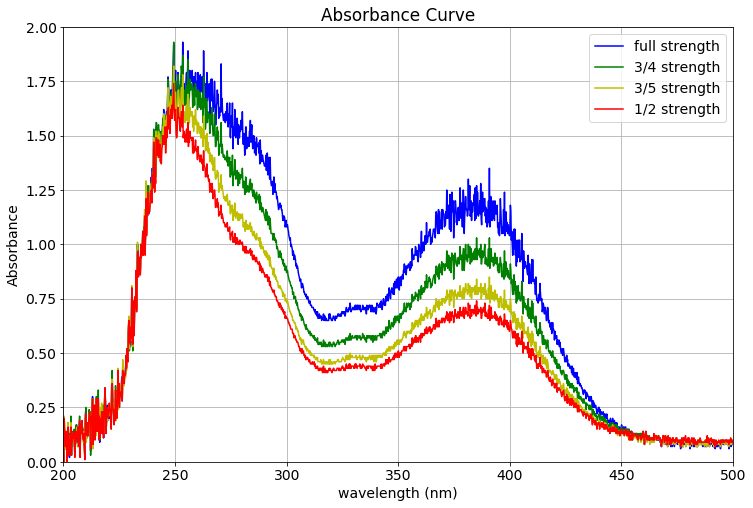

In [5]:
UV_VIS_full_strength_matrix = UV_VIS_full_strength.values
UV_VIS_full_strength_wl = np.array(UV_VIS_full_strength_matrix[:,0], dtype=np.float64)
UV_VIS_full_strength_abs = np.array(UV_VIS_full_strength_matrix[:,1], dtype=np.float64)


UV_VIS_threequarter_strength_matrix = UV_VIS_threequarter_strength.values
UV_VIS_threequarter_strength_wl = np.array(UV_VIS_threequarter_strength_matrix[:,0], dtype=np.float64)
UV_VIS_threequarter_strength_abs = np.array(UV_VIS_threequarter_strength_matrix[:,1], dtype=np.float64)

UV_VIS_threefifth_strength_matrix = UV_VIS_threefifth_strength.values
UV_VIS_threefifth_strength_wl = np.array(UV_VIS_threefifth_strength_matrix[:,0], dtype=np.float64)
UV_VIS_threefifth_strength_abs = np.array(UV_VIS_threefifth_strength_matrix[:,1], dtype=np.float64)

UV_VIS_half_strength_matrix = UV_VIS_half_strength.values
UV_VIS_half_strength_wl = np.array(UV_VIS_half_strength_matrix[:,0], dtype=np.float64)
UV_VIS_half_strength_abs = np.array(UV_VIS_half_strength_matrix[:,1], dtype=np.float64)

plt.plot(UV_VIS_full_strength_wl, UV_VIS_full_strength_abs, 'b', label='full strength')
plt.plot(UV_VIS_threequarter_strength_wl, UV_VIS_threequarter_strength_abs, 'g', label='3/4 strength')
plt.plot(UV_VIS_threefifth_strength_wl, UV_VIS_threefifth_strength_abs, 'y', label='3/5 strength')
plt.plot(UV_VIS_half_strength_wl, UV_VIS_half_strength_abs, 'r', label='1/2 strength')
plt.xlabel('wavelength (nm)')
plt.ylabel('Absorbance')
plt.title('Absorbance Curve')
plt.axis([200, 500, 0, 2.0])
plt.legend(loc=1) #loc 1 is upper right, loc 2 is upper left, loc 3 is lower left, loc 4 is lower right
plt.grid(True)
plt.show()

We need the value of absorbance at 387 nm. According to Prendergast, the extinction coefficient is $\epsilon = 16 400~\rm{M}^{-1}$. We can use Beer's Law to determine the concentration.
$$A = \epsilon c \ell$$
"The thicker the glass, the darker the brew, the less light that gets through." The absorption is proportional to concentration and path length of the light passing through the sample. Our cuvettes are $\ell = 1$ cm.

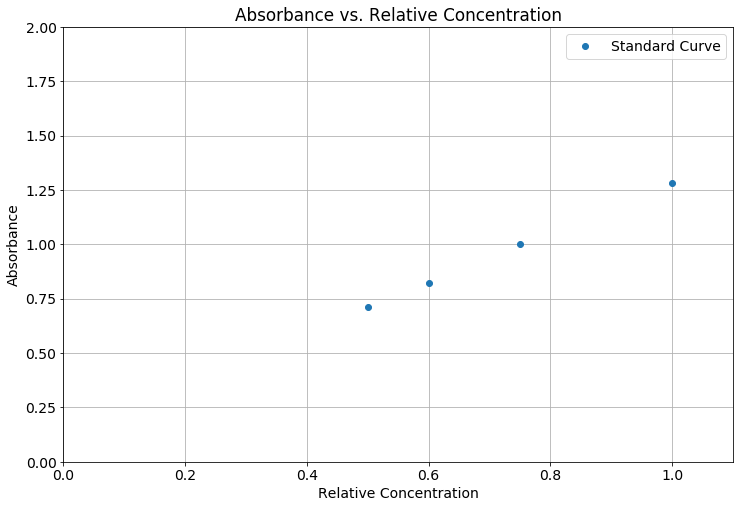

In [6]:
#Find the wavelength closest to 387 nm
UV_VIS_full_strength_wl[np.abs(UV_VIS_full_strength_wl - 387).argmin()]
#Find the index of the wavelength array closest to 387 nm
np.abs(UV_VIS_full_strength_wl - 387).argmin()
#Find the absorption at the index where the wavelength is 387 nm
UV_VIS_full_strength_abs[np.abs(UV_VIS_full_strength_wl - 387).argmin()]

#Let's insert these absorbances into a numpy array as we calculate them.
abs_vs_conc = np.empty((0))
relative_conc = np.empty((0))
relative_conc = np.append(relative_conc, 1)
abs_vs_conc = np.append(abs_vs_conc, UV_VIS_full_strength_abs[np.abs(UV_VIS_full_strength_wl - 387).argmin()])
relative_conc = np.append(relative_conc, 0.75)
abs_vs_conc = np.append(abs_vs_conc, UV_VIS_threequarter_strength_abs[np.abs(UV_VIS_threequarter_strength_wl - 387).argmin()])
relative_conc = np.append(relative_conc, 0.6)
abs_vs_conc = np.append(abs_vs_conc, UV_VIS_threefifth_strength_abs[np.abs(UV_VIS_threefifth_strength_wl - 387).argmin()])
relative_conc = np.append(relative_conc, 0.5)
abs_vs_conc = np.append(abs_vs_conc, UV_VIS_half_strength_abs[np.abs(UV_VIS_half_strength_wl - 387).argmin()])

#Now, we plot it
plt.plot(relative_conc, abs_vs_conc, 'o', label='Standard Curve')
plt.xlabel('Relative Concentration')
plt.ylabel('Absorbance')
plt.title('Absorbance vs. Relative Concentration')
plt.axis([0, 1.1, 0, 2.0])
plt.legend(loc=1) #loc 1 is upper right, loc 2 is upper left, loc 3 is lower left, loc 4 is lower right
plt.grid(True)
plt.show()

That looks pretty linear, which means a calculation of concentration from each value of absorption should be reproducible. Since it doesn't go through the origin, we are probably going to underestimate the concentration, i.e., it should be a steeper slope than what we see. Let's calculate the concentration of each and scale it back to the full concentration. Then, we'll calculate an average and standard error.

In [7]:
concentration_array = abs_vs_conc/relative_conc/16400
print(concentration_array)

average_concentration = np.average(concentration_array)
stderr_concentration = np.std(concentration_array)/np.sqrt(4)
print("{0:8.2e} +/- {1:8.2e}".format(average_concentration, stderr_concentration))

[7.80487805e-05 8.13008130e-05 8.33333333e-05 8.65853659e-05]
8.23e-05 +/- 1.55e-06


Alright, we have a concentration in molarity. From this, you should calculate the amount of beta-mercaptoethanol to have between 2:1 and 5:1 beta-mercaptoethanol to acrylodan. This will ensure that the acrylodan all binds to beta-mercaptoethanol. Since there is no fluorescent behavior of beta-mercaptoethanol, it should not greatly affect your measurements to remain in your solutions. Follow the protocol in article referenced above to react acrylodan with beta-mercaptoethanol. Divide the reaction product into two equal volumes. Dry the solvent (probably acetonitrile). Determine the total volume of solvent to make 11 samples by mixing different ratios of the two solvents from 0% to 100% in 10% increments, e.g., 100% isopropanol, 90:10 isopropanol:water, etc. You will need approximately 3 mL per mixture, 33 mL total.

Collect excitation-emission and time-correlated single photon counting (TCSPC) lifetime data. See the other Jupyter notebook for TCSPC lifetime analysis. Once you have the excitation-emission data, put it into an Excel file with a sheet for excitation, a sheet for normalized (spectrum sums to 1) excitation, a sheet for emission, a sheet for normalized (spectrum sums to 1) excitation. We will load this data into Jupyter now.

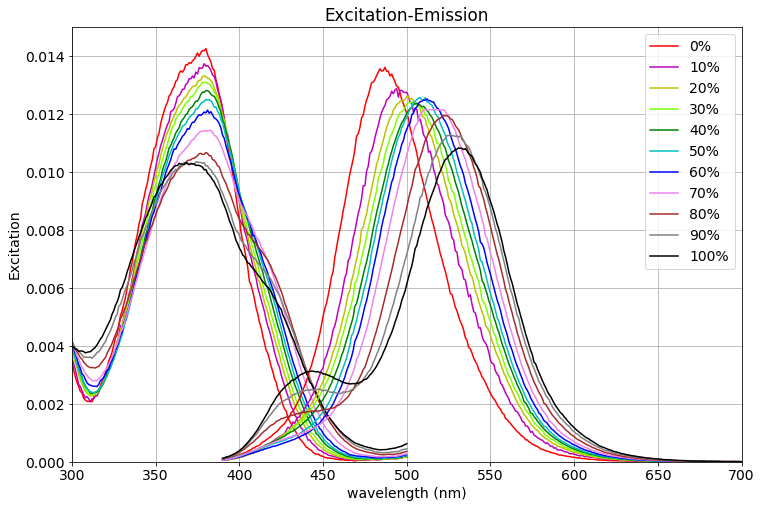

In [15]:
excitation = pd.read_excel('/home/nbuser/library/Excitation-Emission.xlsx', 'excitation_norm', index_col=None, na_values=['NA'])
emission = pd.read_excel('/home/nbuser/library/Excitation-Emission.xlsx', 'emission_norm', index_col=None, na_values=['NA'])

excitation_matrix = excitation.values
excitation_wl = np.array(excitation_matrix[:,0], dtype=np.float64)
excitation_w000 = np.array(excitation_matrix[:,1], dtype=np.float64)
excitation_w010 = np.array(excitation_matrix[:,2], dtype=np.float64)
excitation_w020 = np.array(excitation_matrix[:,3], dtype=np.float64)
excitation_w030 = np.array(excitation_matrix[:,4], dtype=np.float64)
excitation_w040 = np.array(excitation_matrix[:,5], dtype=np.float64)
excitation_w050 = np.array(excitation_matrix[:,6], dtype=np.float64)
excitation_w060 = np.array(excitation_matrix[:,7], dtype=np.float64)
excitation_w070 = np.array(excitation_matrix[:,8], dtype=np.float64)
excitation_w080 = np.array(excitation_matrix[:,9], dtype=np.float64)
excitation_w090 = np.array(excitation_matrix[:,10], dtype=np.float64)
excitation_w100 = np.array(excitation_matrix[:,11], dtype=np.float64)

emission_matrix = emission.values
emission_wl = np.array(emission_matrix[:,0], dtype=np.float64)
emission_w000 = np.array(emission_matrix[:,1], dtype=np.float64)
emission_w010 = np.array(emission_matrix[:,2], dtype=np.float64)
emission_w020 = np.array(emission_matrix[:,3], dtype=np.float64)
emission_w030 = np.array(emission_matrix[:,4], dtype=np.float64)
emission_w040 = np.array(emission_matrix[:,5], dtype=np.float64)
emission_w050 = np.array(emission_matrix[:,6], dtype=np.float64)
emission_w060 = np.array(emission_matrix[:,7], dtype=np.float64)
emission_w070 = np.array(emission_matrix[:,8], dtype=np.float64)
emission_w080 = np.array(emission_matrix[:,9], dtype=np.float64)
emission_w090 = np.array(emission_matrix[:,10], dtype=np.float64)
emission_w100 = np.array(emission_matrix[:,11], dtype=np.float64)

# Have a look at the colormaps here and decide which one you'd like:
# http://matplotlib.org/1.2.1/examples/pylab_examples/show_colormaps.html
#colormap = plt.cm.gist_ncar
#Add excitation plots
plt.plot(excitation_wl, excitation_w000, 'r', label='0%')
plt.plot(excitation_wl, excitation_w010, 'm', label='10%')
plt.plot(excitation_wl, excitation_w020, 'y', label='20%')
plt.plot(excitation_wl, excitation_w030, 'chartreuse', label='30%')
plt.plot(excitation_wl, excitation_w040, 'g', label='40%')
plt.plot(excitation_wl, excitation_w050, 'c', label='50%')
plt.plot(excitation_wl, excitation_w060, 'b', label='60%')
plt.plot(excitation_wl, excitation_w070, 'violet', label='70%')
plt.plot(excitation_wl, excitation_w080, 'brown', label='80%')
plt.plot(excitation_wl, excitation_w090, 'gray', label='90%')
plt.plot(excitation_wl, excitation_w100, 'k', label='100%')
#Add emission plots
plt.plot(emission_wl, emission_w000, 'r')
plt.plot(emission_wl, emission_w010, 'm')
plt.plot(emission_wl, emission_w020, 'y')
plt.plot(emission_wl, emission_w030, 'chartreuse')
plt.plot(emission_wl, emission_w040, 'g')
plt.plot(emission_wl, emission_w050, 'c')
plt.plot(emission_wl, emission_w060, 'b')
plt.plot(emission_wl, emission_w070, 'violet')
plt.plot(emission_wl, emission_w080, 'brown')
plt.plot(emission_wl, emission_w090, 'gray')
plt.plot(emission_wl, emission_w100, 'k')
plt.xlabel('wavelength (nm)')
plt.ylabel('Excitation')
plt.title('Excitation-Emission')
plt.axis([300, 700, 0, 0.015])
plt.legend(loc=1) #loc 1 is upper right, loc 2 is upper left, loc 3 is lower left, loc 4 is lower right
plt.grid(True)
plt.show()

Beautiful! Now, let's see how the peaks are shifting both along the wavelength direction and how the intensity is changing. This could be done using the same process as above with the absorption. However, I have already done the analysis in the Excel file. So, I'm going to bring that data into Jupyter. Why use Jupyter, you ask? Because I can add this description of what I'm doing, and the graphs are prettier.

In [16]:
Trends = pd.read_excel('/home/nbuser/library/Excitation-Emission.xlsx', 'Analysis', index_col=None, na_values=['NA'])

Trends_matrix = Trends.values
water_concentration = np.array(Trends_matrix[:,0], dtype=np.float64)
MaxExWL = np.array(Trends_matrix[:,1], dtype=np.float64)
MaxEmWL = np.array(Trends_matrix[:,2], dtype=np.float64)
MaxExIntense = np.array(Trends_matrix[:,3], dtype=np.float64)
MaxEmIntense = np.array(Trends_matrix[:,4], dtype=np.float64)

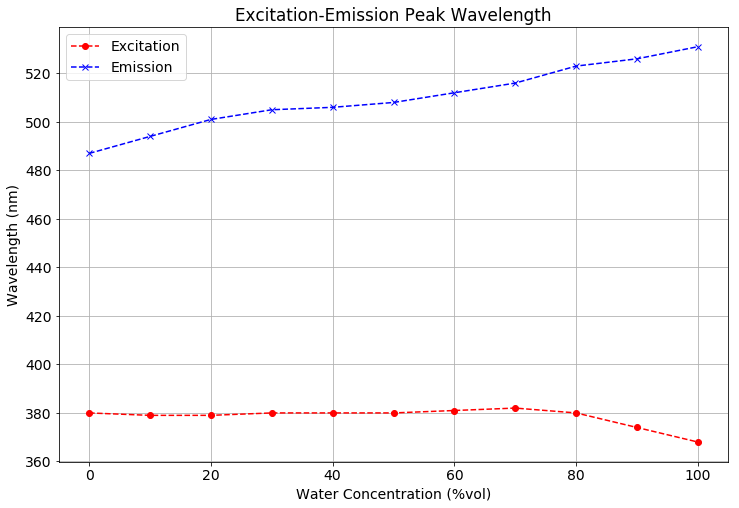

In [21]:
plt.plot(water_concentration, MaxExWL, '--or', label='Excitation')
plt.plot(water_concentration, MaxEmWL, '--xb', label='Emission')
plt.xlabel('Water Concentration (%vol)')
plt.ylabel('Wavelength (nm)')
plt.title('Excitation-Emission Peak Wavelength')
#plt.axis([300, 700, 0, 0.015])
plt.legend(loc=2) #loc 1 is upper right, loc 2 is upper left, loc 3 is lower left, loc 4 is lower right
plt.grid(True)
plt.show()

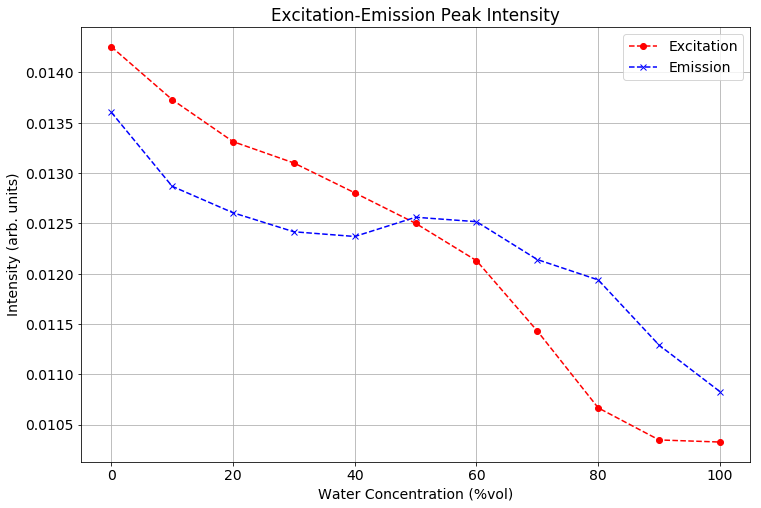

In [24]:
plt.plot(water_concentration, MaxExIntense, '--or', label='Excitation')
plt.plot(water_concentration, MaxEmIntense, '--xb', label='Emission')
plt.xlabel('Water Concentration (%vol)')
plt.ylabel('Intensity (arb. units)')
plt.title('Excitation-Emission Peak Intensity')
#plt.axis([300, 700, 0, 0.015])
plt.legend(loc=1) #loc 1 is upper right, loc 2 is upper left, loc 3 is lower left, loc 4 is lower right
plt.grid(True)
plt.show()

The fits for green and blue are pretty bad! Let's look at another method. We can fit the exponential rise to a line and see where it projects back onto the x-axis. To do this, we need to figure out what range of LEDVoltage corresponds to the rise. Let's do this one by one.

The blue curve appears to turn up after about 2.6 Volts.

The green curve appears to turn up after about 2.2 Volts.

The yellow curve appears to turn up after about 1.7 Volts.

The red curve appears to turn up after about 1.6 Volts.

We will need to adjust these to get the best fit. This can be accomplished by trying to minimize the covariant matrix diagonal elements. We'll do this by eye.